In [242]:
#coding:utf-8
from math import log
import operator

#计算熵
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    #为所有可能的分类创造词典
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shanononEnt = 0.0
    for key in labelCounts:
        #以2为底求导数
        prob = float(labelCounts[key])/numEntries
        #计算熵
        shanononEnt -= prob * log(prob,2)
    return shanononEnt


#得到简单的鉴定数据集
def createDataSet():
    dataSet = [[1,1,'yes'],[1,1,'yes'],[0,0,'yes'],[0,1,'no'],[1,0,'no'],[1,0,'no']]
    labels = ['no surfacing','flippers']
    return dataSet,labels

#划分数据集
def splitDataSet(dataSet, axis, value):
    #创建新的list对象
    retDataSet = []
    for featVec in dataSet:
        #抽取
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]     
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
            #extend是将元素一个一个添加到尾部，append是将整个集合添加到尾部
    return retDataSet

#选择最好的数据集划分方式
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1   
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0; bestFeature = -1
    for i in range(numFeatures):  #遍历所有的特征
        featList = [example[i] for example in dataSet]#为没哟个特征创建一个集合
        uniqueVals = set(featList)       #get a set of unique values
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)     
        infoGain = baseEntropy - newEntropy     #calculate the info gain; ie reduction in entropy
        if (infoGain > bestInfoGain):       
            bestInfoGain = infoGain         #进行判定，取大的熵差，即划分后的熵与原熵的差值，同时得到最大特征数
            bestFeature = i
    return bestFeature 


#表决方法
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classList.keys(): classCount[vote] =0
        classCount[vote] += 1
        #operate方法操作键值排序字典
    sortedClassCount = sorted(classCount.iteritems(),key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]
    
    
#创建树
def createTree(dataSet,labels):
    #在这里首先需要将递归结束的条件即类别完全相同的停止划分
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):
        #所有类标签完全相同，即类标签集合中包含的类标签数目和类标签集合长度相同时,直接返回类标签
        return classList[0]
    
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)
    
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    
    for value in uniqueVals:
        #复制标签类
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet,bestFeat,value),subLabels)
    return myTree


#用matplotlib创建文本注解树形图
import matplotlib.pyplot as plt
decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',
             xytext=centerPt, textcoords='axes fraction',
             va="center", ha="center", bbox=nodeType, arrowprops=arrow_args )
    
def createPlot():
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    createPlot.ax1 = plt.subplot(111, frameon=False)
    plotNode('decision point',(0.5,0.1),(0.1,0.5),decisionNode)
    plotNode('leaf point',(0.8,0.1),(0.3,0.8),decisionNode)
    plt.show()
    
#为了绘制整个图需要知道叶节点的数目和树的层数
def getNumLeafs(myTree):
    numLeafs = 0
    #在2.7中，找到key所对应的第一个元素为：firstStr = myTree.keys()[0]，这在3.4中运行会报错：‘dict_keys‘ object does not support indexing，这是因为python3改变了dict.keys,返回的是dict_keys对象,支持iterable 但不支持indexable，我们可以将其明确的转化成list，
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#判断节点数据是否为字典
            numLeafs += getNumLeafs(secondDict[key])
        else:   numLeafs +=1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#判断节点数据是否为字典
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:   thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

#预先存储树的信息，用于测试
def retrieveTree(i):
    listOfTrees =[{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                  {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return listOfTrees[i]

#父子节点间填充文本信息
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)  
    depth = getTreeDepth(myTree)
    firstSides = list(myTree.keys())
    firstStr = firstSides[0]#找到输入的第一个元素
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt) #标记子节点属性
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD#减少y偏移量
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':   
            plotTree(secondDict[key],cntrPt,str(key))        
        else:   
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()
    
    
    
    
#测试算法，使用决策树执行分类
def classify(inputTree,featLabels,testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)#将标签字符转化成索引
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__=='dict':
                classLabel = classify(secondDict[key],featLabels,testVec)
            else: classLabel = secondDict[key]#如果到达子节点，返回当前节点的分类标签
    return classLabel

def storeTree(inputTree,filename):
    import pickle
    fw = open(filename,'wb')
    pickle.dump(inputTree,fw)
    fw.close()
    
def grabTree(filename):
    import pickle
    fr = open(filename,'rb')
    return pickle.load(fr)

In [211]:
myDat,labels= createDataSet()
classList = [example[-1] for example in myDat]
classList[0]
classList.count(classList[0]) == len(classList)

False

In [212]:
labels


['no surfacing', 'flippers']

In [9]:
calcShannonEnt(myDat)

1.0

In [65]:
myDat[0][-1] = 'xyd'
myDat

[[1, 1, 'xyd'],
 [1, 1, 'yes'],
 [0, 0, 'yes'],
 [0, 1, 'no'],
 [1, 0, 'no'],
 [1, 0, 'no']]

In [17]:
calcShannonEnt(myDat)

1.4591479170272448

In [200]:
myDat,labels= createDataSet()
myDat
myDat[0]
len(myDat[5])

3

In [26]:
splitDataSet(myDat,0,1)

[[1, 'yes'], [1, 'yes'], [0, 'no'], [0, 'no']]

In [27]:
myDat,labels= createDataSet()

In [30]:
chooseBestFeatureToSplit(myDat)

1

In [191]:
myDat
myTree.keys()

dict_keys(['no surfacing'])

In [167]:
myDat,labels= createDataSet()
myTree = createTree(myDat,labels)
myTree

{'没有脚蹼的': {0: {'不浮出水面也能生存': {0: 'yes', 1: 'no'}},
  1: {'不浮出水面也能生存': {0: 'no', 1: 'yes'}}}}

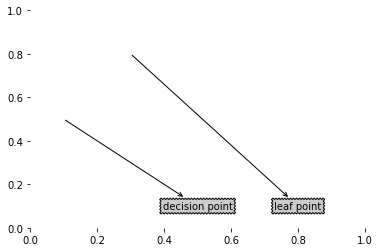

In [150]:
createPlot()

In [213]:
#这是用于测试的数据
myTree = retrieveTree(0)
myTree


{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [182]:
getNumLeafs(myTree)

3

In [184]:
getTreeDepth(myTree)

2

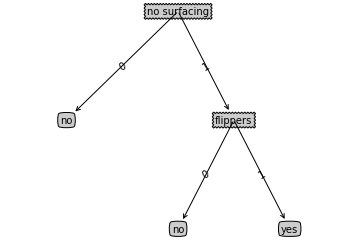

In [208]:
myTree = retrieveTree(0)
createPlot(myTree)

In [196]:
myTree['no surfacing'][3] = 'maybe'
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}, 3: 'maybe'}}

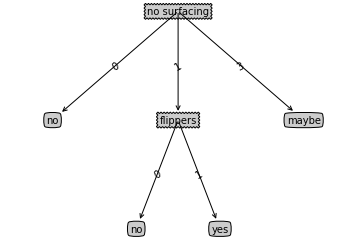

In [202]:
createPlot(myTree)

In [217]:
classify(myTree,labels,[1,1])

'yes'

In [223]:
firstStr = list(myTree.keys())[0]
secondDict = myTree[firstStr]
secondDict

{0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}

In [244]:
storeTree(myTree,'G:/Anaconda/MachineLearning_Action/Tree/classifierStorage.txt')
grabTree('G:/Anaconda/MachineLearning_Action/Tree/classifierStorage.txt')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [248]:
fr = open('E:/谢远东/机器学习/机器学习实践/机器学习实战源代码/machinelearninginaction/Ch03/lenses.txt')
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels = ['age','prescript','astigmatic','tearRate']
lensesTree = createTree(lenses,lensesLabels)
lensesTree


{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'pre': 'soft',
      'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}},
      'young': 'soft'}},
    'yes': {'prescript': {'hyper': {'age': {'pre': 'no lenses',
        'presbyopic': 'no lenses',
        'young': 'hard'}},
      'myope': 'hard'}}}},
  'reduced': 'no lenses'}}

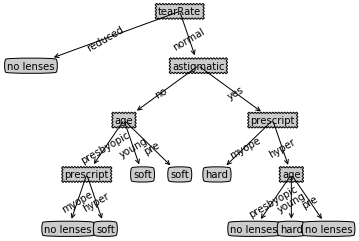

In [249]:
createPlot(lensesTree)